<a href="https://colab.research.google.com/github/xinyuezhang-shirley/cs229FinalProject/blob/main/CS229_ProjectionLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training hyperparameters
BATCH_SIZE = 256
EPOCHS = 500              # maximum epochs (early stop may cut short)
LR = 1e-3                 # base learning rate (after warmup)
TEMP = 0.1                # InfoNCE temperature
SAMPLES_PER_EPOCH = 10000 # number of training samples per epoch

# Learning rate schedule / early stopping
WARMUP_EPOCHS = 5         # linear warmup epochs
MIN_LR = 1e-5             # final minimum LR for cosine schedule
USE_COSINE_SCHEDULE = True
EARLY_STOP_PATIENCE = 25  # epochs (post-warmup) with no sufficient improvement
EARLY_STOP_DELTA = 0.002  # required loss decrease to reset patience
MOVING_AVG_WINDOW = 10    # for smoothed loss (used only for reporting)

# Modality weights (kept same)
ALPHA = 0.6       # MPNet branch
BETA_EMO = 0.1    # emotion semantics
BETA_THEME = 0.15 # theme semantics
BETA_OTHER = 0.1  # other semantics (sentiment, subjectivity, concreteness, energy, narrative, imagery)
GAMMA = 0.15      # structural/lexical branch

# Unsupervised pair construction hyperparameters
POS_TOPK = 10        # positives per poem from similarity
HARD_TOPK = 20       # hard negatives per poem (near misses)
EASY_THRESHOLD = 0.15  # cosine threshold for easy negatives

In [ ]:
# MPNet embeddings (raw, not yet filtered)
poem_vecs = np.load("data/processed/mpnet_embeddings_poems.npy")
song_vecs = np.load("data/processed/mpnet_embeddings_songs.npy")

# Load all features from full_features.npz
full = np.load("data/processed/full_features.npz", allow_pickle=True)

# Structural + lexical features (concatenated)
poem_struct = full["poem_struct"]  # (3413, 3)
poem_lexical = full["poem_lexical"]  # (3413, 3)
poem_feats = np.concatenate([poem_struct, poem_lexical], axis=1)  # (3413, 6)

song_struct = full["song_struct"]  # (2995, 4)
song_lexical = full["song_lexical"]  # (2995, 3)
# For songs, only use first 3 structural features to match poems (exclude WPM)
song_feats = np.concatenate([song_struct[:, :3], song_lexical], axis=1)  # (2995, 6)

# Semantic features
poem_sem_all = full["poem_semantic"]  # (3413, 36)
song_sem_all = full["song_semantic"]  # (2995, 36)

# Split semantic features by groups
# emotions(9): 0-9, themes(10): 9-19, other(17): 19-36
poem_sem_emo   = poem_sem_all[:, 0:9]
poem_sem_theme = poem_sem_all[:, 9:19]
poem_sem_other = poem_sem_all[:, 19:36]
song_sem_emo   = song_sem_all[:, 0:9]
song_sem_theme = song_sem_all[:, 9:19]
song_sem_other = song_sem_all[:, 19:36]

# Align song embeddings to match cleaned features
idx_map = full["song_source_indexes"]  # (2995,) maps cleaned songs -> raw embedding indices
song_vecs = song_vecs[idx_map]  # reorder raw embeddings to match cleaned data

print(f"Poems: {poem_vecs.shape[0]} items")
print(f"Songs: {song_vecs.shape[0]} items")
print(f"poem_vecs: {poem_vecs.shape}, song_vecs: {song_vecs.shape}")
print(f"poem_feats: {poem_feats.shape}, song_feats: {song_feats.shape}")
print(f"poem_sem (emo/theme/other): {poem_sem_emo.shape}, {poem_sem_theme.shape}, {poem_sem_other.shape}")
print(f"song_sem (emo/theme/other): {song_sem_emo.shape}, {song_sem_theme.shape}, {song_sem_other.shape}")


(3413, 768) (2934, 768)
(3413, 3) (2934, 4)


In [ ]:
# Normalize MPNet embeddings per row to balance scales
poem_vecs = poem_vecs / (np.linalg.norm(poem_vecs, axis=1, keepdims=True) + 1e-8)
song_vecs = song_vecs / (np.linalg.norm(song_vecs, axis=1, keepdims=True) + 1e-8)

# Build branch inputs
poem_in = {
    "mpnet": poem_vecs,
    "sem_emo":   poem_sem_emo,
    "sem_theme": poem_sem_theme,
    "sem_other": poem_sem_other,
    "feat":  poem_feats,
}
song_in = {
    "mpnet": song_vecs,
    "sem_emo":   song_sem_emo,
    "sem_theme": song_sem_theme,
    "sem_other": song_sem_other,
    "feat":  song_feats,
}

print("poem branches:", poem_in["mpnet"].shape, poem_in["sem_emo"].shape, poem_in["sem_theme"].shape, poem_in["sem_other"].shape, poem_in["feat"].shape)
print("song  branches:", song_in["mpnet"].shape, song_in["sem_emo"].shape, song_in["sem_theme"].shape, song_in["sem_other"].shape, song_in["feat"].shape)

# Compute or load precomputed pairwise cosine similarity matrix
import torch
import os

cosine_matrix_path = "data/processed/mpnet_pairwise_cosine_matrix.npy"

if os.path.exists(cosine_matrix_path):
    print(f"Loading precomputed cosine matrix from {cosine_matrix_path}...")
    cos_matrix_t = torch.from_numpy(np.load(cosine_matrix_path)).to(DEVICE)
    print(f"Loaded matrix shape: {cos_matrix_t.shape}")
else:
    print("Computing pairwise cosine similarity matrix on GPU...")
    # Move MPNet branches to GPU tensors
    p_mp = torch.from_numpy(poem_in["mpnet"]).to(torch.float32).to(DEVICE)
    s_mp = torch.from_numpy(song_in["mpnet"]).to(torch.float32).to(DEVICE)
    
    # Compute cosine similarity matrix via matmul on GPU (all poem-song pairs)
    cos_matrix_t = torch.matmul(p_mp, s_mp.T)  # [P, S]
    
    # Save to cache
    np.save(cosine_matrix_path, cos_matrix_t.cpu().numpy())
    print(f"Saved cosine matrix to {cosine_matrix_path}")

# Build pos/hard/neg pairs from current hyperparameters (always recompute based on thresholds)
print(f"Building pairs with POS_TOPK={POS_TOPK}, HARD_TOPK={HARD_TOPK}, EASY_THRESHOLD={EASY_THRESHOLD}...")
P, S = cos_matrix_t.shape
pos_pairs = []
hard_pairs = []
neg_pairs = []

with torch.no_grad():
    # For each poem, get top (POS_TOPK + HARD_TOPK) indices
    topk_vals, topk_idxs = torch.topk(cos_matrix_t, k=min(S, POS_TOPK + HARD_TOPK), dim=1, largest=True, sorted=True)

    # Build pos and hard lists
    for i in range(P):
        # positives
        for j in topk_idxs[i, :POS_TOPK].tolist():
            pos_pairs.append((int(i), int(j)))
        # hard negatives (near misses)
        for j in topk_idxs[i, POS_TOPK:POS_TOPK+HARD_TOPK].tolist():
            hard_pairs.append((int(i), int(j)))

    # Easy negatives: cosine below threshold; sample a few per poem
    easy_mask = cos_matrix_t <= EASY_THRESHOLD
    for i in range(P):
        low_idxs = torch.nonzero(easy_mask[i], as_tuple=False).squeeze(-1).cpu().numpy()
        if low_idxs.size > 0:
            sample_ct = min(5, low_idxs.size)
            choice = np.random.choice(low_idxs, size=sample_ct, replace=False)
            for j in choice:
                neg_pairs.append((int(i), int(j)))

print(f"Built pairs -> pos: {len(pos_pairs)} hard: {len(hard_pairs)} easy: {len(neg_pairs)}")

poem_in: (3413, 771)
song_in: (2934, 772)


In [ ]:
class PairDataset(Dataset):
    def __init__(self, pos_pairs, neg_pairs, hard_pairs, size):
        """
        Returns poem/song indices for each sample.
        size = number of samples per epoch
        """
        self.pos_pairs  = pos_pairs
        self.neg_pairs  = neg_pairs
        self.hard_pairs = hard_pairs
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Sample random positive pair
        i_poem, j_song = self.pos_pairs[np.random.randint(len(self.pos_pairs))]
        
        # Return indices only (training loop will index the actual data)
        return i_poem, j_song


In [ ]:
dataset = PairDataset(
    pos_pairs,
    neg_pairs,
    hard_pairs,
    size=SAMPLES_PER_EPOCH
)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 for simpler debugging; increase on CPU
    pin_memory=False
)

# Pre-build GPU tensors for all data (avoids repeated CPU->GPU transfers)
poem_gpu = {
    "mpnet": torch.from_numpy(poem_in["mpnet"]).to(torch.float32).to(DEVICE),
    "sem_emo": torch.from_numpy(poem_in["sem_emo"]).to(torch.float32).to(DEVICE),
    "sem_theme": torch.from_numpy(poem_in["sem_theme"]).to(torch.float32).to(DEVICE),
    "sem_other": torch.from_numpy(poem_in["sem_other"]).to(torch.float32).to(DEVICE),
    "feat": torch.from_numpy(poem_in["feat"]).to(torch.float32).to(DEVICE),
}
song_gpu = {
    "mpnet": torch.from_numpy(song_in["mpnet"]).to(torch.float32).to(DEVICE),
    "sem_emo": torch.from_numpy(song_in["sem_emo"]).to(torch.float32).to(DEVICE),
    "sem_theme": torch.from_numpy(song_in["sem_theme"]).to(torch.float32).to(DEVICE),
    "sem_other": torch.from_numpy(song_in["sem_other"]).to(torch.float32).to(DEVICE),
    "feat": torch.from_numpy(song_in["feat"]).to(torch.float32).to(DEVICE),
}

print(f"Pre-built GPU tensors for {poem_gpu['mpnet'].shape[0]} poems and {song_gpu['mpnet'].shape[0]} songs")

In [ ]:
# Branch sizes
p_dim_mp = poem_in["mpnet"].shape[1]
p_dim_emo = poem_in["sem_emo"].shape[1]
p_dim_theme = poem_in["sem_theme"].shape[1]
p_dim_other = poem_in["sem_other"].shape[1]
p_dim_ft  = poem_in["feat"].shape[1]
s_dim_mp = song_in["mpnet"].shape[1]
s_dim_emo = song_in["sem_emo"].shape[1]
s_dim_theme = song_in["sem_theme"].shape[1]
s_dim_other = song_in["sem_other"].shape[1]
s_dim_ft  = song_in["feat"].shape[1]
proj_dim = 128

class ProjectionModel(nn.Module):
    def __init__(self, p_dims, s_dims, proj_dim):
        super().__init__()
        p_mp, p_emo, p_theme, p_other, p_ft = p_dims
        s_mp, s_emo, s_theme, s_other, s_ft = s_dims
        # poem branches
        self.poem_mp = nn.Sequential(nn.Linear(p_mp, 256), nn.ReLU(), nn.Linear(256, 128))
        self.poem_emo = nn.Sequential(nn.Linear(max(p_emo,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.poem_theme = nn.Sequential(nn.Linear(max(p_theme,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.poem_other = nn.Sequential(nn.Linear(max(p_other,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.poem_ft = nn.Sequential(nn.Linear(p_ft, 64), nn.ReLU(), nn.Linear(64, 64))
        self.poem_proj = nn.Sequential(nn.LayerNorm(128+64+64+64+64), nn.Linear(128+64+64+64+64, proj_dim))
        # song branches
        self.song_mp = nn.Sequential(nn.Linear(s_mp, 256), nn.ReLU(), nn.Linear(256, 128))
        self.song_emo = nn.Sequential(nn.Linear(max(s_emo,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.song_theme = nn.Sequential(nn.Linear(max(s_theme,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.song_other = nn.Sequential(nn.Linear(max(s_other,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.song_ft = nn.Sequential(nn.Linear(s_ft, 64), nn.ReLU(), nn.Linear(64, 64))
        self.song_proj = nn.Sequential(nn.LayerNorm(128+64+64+64+64), nn.Linear(128+64+64+64+64, proj_dim))
    def forward_poem(self, p):
        mp = self.poem_mp(p["mpnet"])
        emo_in = p["sem_emo"] if p_dim_emo>0 else torch.zeros(p["mpnet"].shape[0], 1, device=p["mpnet"].device)
        theme_in = p["sem_theme"] if p_dim_theme>0 else torch.zeros(p["mpnet"].shape[0], 1, device=p["mpnet"].device)
        other_in = p["sem_other"] if p_dim_other>0 else torch.zeros(p["mpnet"].shape[0], 1, device=p["mpnet"].device)
        emo = self.poem_emo(emo_in)
        theme = self.poem_theme(theme_in)
        other = self.poem_other(other_in)
        ft  = self.poem_ft(p["feat"])
        comb = torch.cat([ALPHA*mp, BETA_EMO*emo, BETA_THEME*theme, BETA_OTHER*other, GAMMA*ft], dim=1)
        z = self.poem_proj(comb)
        return F.normalize(z, dim=1)
    def forward_song(self, s):
        mp = self.song_mp(s["mpnet"])
        emo_in = s["sem_emo"] if s_dim_emo>0 else torch.zeros(s["mpnet"].shape[0], 1, device=s["mpnet"].device)
        theme_in = s["sem_theme"] if s_dim_theme>0 else torch.zeros(s["mpnet"].shape[0], 1, device=s["mpnet"].device)
        other_in = s["sem_other"] if s_dim_other>0 else torch.zeros(s["mpnet"].shape[0], 1, device=s["mpnet"].device)
        emo = self.song_emo(emo_in)
        theme = self.song_theme(theme_in)
        other = self.song_other(other_in)
        ft  = self.song_ft(s["feat"])
        comb = torch.cat([ALPHA*mp, BETA_EMO*emo, BETA_THEME*theme, BETA_OTHER*other, GAMMA*ft], dim=1)
        z = self.song_proj(comb)
        return F.normalize(z, dim=1)

In [ ]:
def clip_loss(p_z, s_z, temperature=TEMP):
    # InfoNCE symmetric loss
    logits = (p_z @ s_z.T) / temperature
    labels = torch.arange(logits.shape[0], device=logits.device)
    loss_p_to_s = F.cross_entropy(logits, labels)
    loss_s_to_p = F.cross_entropy(logits.T, labels)
    return (loss_p_to_s + loss_s_to_p) / 2

In [ ]:
# Build model filename from hyperparameters
model_name = (f"model_bs{BATCH_SIZE}_ep{EPOCHS}_lr{LR}_temp{TEMP}_"
             f"posK{POS_TOPK}_hardK{HARD_TOPK}_"
             f"a{ALPHA}_bemo{BETA_EMO}_bthm{BETA_THEME}_both{BETA_OTHER}_g{GAMMA}.pt")

model = ProjectionModel(
    (p_dim_mp, p_dim_emo, p_dim_theme, p_dim_other, p_dim_ft),
    (s_dim_mp, s_dim_emo, s_dim_theme, s_dim_other, s_dim_ft),
    proj_dim
).to(DEVICE)

# Check if model already exists
if os.path.exists(model_name):
    print(f"Loading existing model from {model_name}...")
    model.load_state_dict(torch.load(model_name, map_location=DEVICE))
    print("Model loaded. Skipping training.")
    SKIP_TRAINING = True
else:
    print(f"No existing model found. Will train and save to {model_name}")
    SKIP_TRAINING = False

opt = torch.optim.Adam(model.parameters(), lr=LR)

# Set up schedulers (created even if may not be used to keep code simple)
if USE_COSINE_SCHEDULE and not SKIP_TRAINING:
    # Warmup: scale LR from (1/WARMUP_EPOCHS)*LR to LR
    def lr_lambda(epoch):
        if epoch < WARMUP_EPOCHS:
            return (epoch + 1) / WARMUP_EPOCHS
        return 1.0
    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)
    # Cosine anneal after warmup
    scheduler_main = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS - WARMUP_EPOCHS, eta_min=MIN_LR)
else:
    warmup_scheduler = None
    scheduler_main = None

In [ ]:
if not SKIP_TRAINING:
    loss_history = []            # raw epoch loss for plotting
    lr_history = []
    best_smooth = float('inf')   # track best smoothed loss for early stopping
    epochs_no_improve = 0
    smooth_history = []  # window of recent raw losses for smoothing

    for epoch in range(EPOCHS):
        model.train()
        total = 0.0

        for poem_idxs, song_idxs in loader:
            # Index pre-built GPU tensors with batch indices
            p_batch = {
                "mpnet": poem_gpu["mpnet"][poem_idxs],
                "sem_emo": poem_gpu["sem_emo"][poem_idxs],
                "sem_theme": poem_gpu["sem_theme"][poem_idxs],
                "sem_other": poem_gpu["sem_other"][poem_idxs],
                "feat": poem_gpu["feat"][poem_idxs],
            }
            s_batch = {
                "mpnet": song_gpu["mpnet"][song_idxs],
                "sem_emo": song_gpu["sem_emo"][song_idxs],
                "sem_theme": song_gpu["sem_theme"][song_idxs],
                "sem_other": song_gpu["sem_other"][song_idxs],
                "feat": song_gpu["feat"][song_idxs],
            }

            # Forward
            p_z = model.forward_poem(p_batch)
            s_z = model.forward_song(s_batch)

            # Contrastive loss
            loss = clip_loss(p_z, s_z)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total += loss.item()

        avg = total / len(loader)          # raw epoch loss
        loss_history.append(avg)           # store raw for plotting only

        # Update smoothing window and compute smoothed loss
        smooth_history.append(avg)
        if len(smooth_history) > MOVING_AVG_WINDOW:
            smooth_history.pop(0)
        smooth_avg = sum(smooth_history) / len(smooth_history)

        # Scheduler step
        if USE_COSINE_SCHEDULE:
            if epoch < WARMUP_EPOCHS:
                warmup_scheduler.step()
            else:
                scheduler_main.step()
        current_lr = opt.param_groups[0]['lr']
        lr_history.append(current_lr)

        # Early stopping uses smoothed loss (post-warmup)
        if epoch >= WARMUP_EPOCHS:
            if smooth_avg < best_smooth - EARLY_STOP_DELTA:
                best_smooth = smooth_avg
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            if epochs_no_improve >= EARLY_STOP_PATIENCE:
                print(f"Early stopping at epoch {epoch+1}: smoothed loss no improvement > {EARLY_STOP_DELTA} for {EARLY_STOP_PATIENCE} epochs.")
                break

        print(f"epoch {epoch+1}/{EPOCHS} lr={current_lr:.6f} raw_loss={avg:.4f} smooth_loss={smooth_avg:.4f}")
else:
    print("Using loaded model; skipping training loop.")
    loss_history = []  # empty since no training occurred
    lr_history = []

/Users/shirleyzhang/Desktop/CS229/cs229FinalProject/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Traceback (most recent call last):
  File "<string>", line 1, in <module>
    from multiprocessing.spawn import spawn_main; spawn_main(tracker_fd=93, pipe_handle=107)
                                                  ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'PairDataset' on <module '__main__' (<class 

KeyboardInterrupt: 

In [ ]:
if not SKIP_TRAINING:
    torch.save(model.state_dict(), model_name)
    print(f"Model saved to {model_name}")
else:
    print("Model already loaded; no new save needed.")

Model saved.


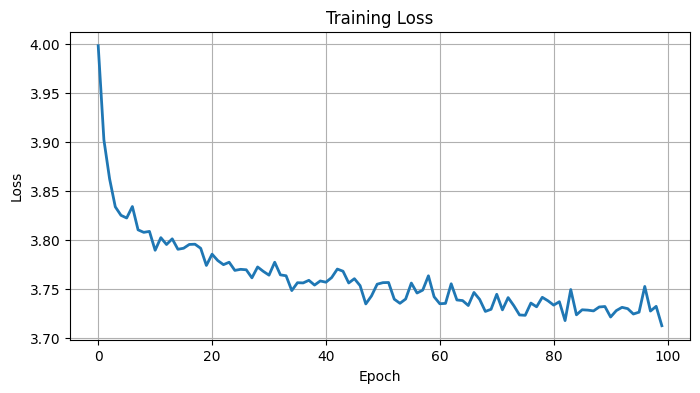

In [ ]:
if len(loss_history) > 0:
    plt.figure(figsize=(8,4))
    plt.plot(loss_history, linewidth=2)
    plt.title("Training Loss (Contrastive Only)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
else:
    print("No training occurred (model was loaded); skipping loss plot.")

In [ ]:
# Evaluation: Compare raw MPNet cosine vs learned embeddings

model.eval()
with torch.no_grad():
    # Project all poems and songs through trained model
    poem_batch = {
        "mpnet": torch.from_numpy(poem_in["mpnet"]).to(torch.float32).to(DEVICE),
        "sem_emo": torch.from_numpy(poem_in["sem_emo"]).to(torch.float32).to(DEVICE),
        "sem_theme": torch.from_numpy(poem_in["sem_theme"]).to(torch.float32).to(DEVICE),
        "sem_other": torch.from_numpy(poem_in["sem_other"]).to(torch.float32).to(DEVICE),
        "feat": torch.from_numpy(poem_in["feat"]).to(torch.float32).to(DEVICE),
    }
    song_batch = {
        "mpnet": torch.from_numpy(song_in["mpnet"]).to(torch.float32).to(DEVICE),
        "sem_emo": torch.from_numpy(song_in["sem_emo"]).to(torch.float32).to(DEVICE),
        "sem_theme": torch.from_numpy(song_in["sem_theme"]).to(torch.float32).to(DEVICE),
        "sem_other": torch.from_numpy(song_in["sem_other"]).to(torch.float32).to(DEVICE),
        "feat": torch.from_numpy(song_in["feat"]).to(torch.float32).to(DEVICE),
    }
    
    learned_poem_z = model.forward_poem(poem_batch)
    learned_song_z = model.forward_song(song_batch)
    
    # Compute learned cosine matrix
    learned_cos_matrix = (learned_poem_z @ learned_song_z.T).cpu().numpy()

# Raw MPNet cosine matrix (already computed, on GPU)
raw_cos_matrix = cos_matrix_t.cpu().numpy()

# Extract cosines for positive and negative pairs
pos_raw = [raw_cos_matrix[i, j] for i, j in pos_pairs]
pos_learned = [learned_cos_matrix[i, j] for i, j in pos_pairs]

# Sample negatives (combine hard + easy for comparison)
all_neg_pairs = hard_pairs + neg_pairs
neg_sample = np.random.choice(len(all_neg_pairs), size=min(5000, len(all_neg_pairs)), replace=False)
neg_raw = [raw_cos_matrix[all_neg_pairs[idx][0], all_neg_pairs[idx][1]] for idx in neg_sample]
neg_learned = [learned_cos_matrix[all_neg_pairs[idx][0], all_neg_pairs[idx][1]] for idx in neg_sample]

print(f"Positive pairs: {len(pos_raw)}, Negative sample: {len(neg_raw)}")

In [ ]:
# Plot 1: Histogram of positive vs negative cosines (raw vs learned)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw MPNet
axes[0].hist(pos_raw, bins=50, alpha=0.7, label='Positives', color='green')
axes[0].hist(neg_raw, bins=50, alpha=0.7, label='Negatives', color='red')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Raw MPNet Embeddings')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learned embeddings
axes[1].hist(pos_learned, bins=50, alpha=0.7, label='Positives', color='green')
axes[1].hist(neg_learned, bins=50, alpha=0.7, label='Negatives', color='red')
axes[1].set_xlabel('Cosine Similarity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Learned Embeddings (After Training)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Plot 2: Scatter plot of positive pair cosines (raw vs learned)

plt.figure(figsize=(7, 7))
plt.scatter(pos_raw, pos_learned, alpha=0.5, s=10, color='blue')
plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='y=x (no improvement)')  # diagonal
plt.xlabel('Raw MPNet Cosine')
plt.ylabel('Learned Cosine')
plt.title('Positive Pairs: Raw vs Learned Similarity\n(Points above diagonal = improvement)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
# Plot 3: Box plot of margin (positive - negative) for raw vs learned

# Compute margins: for each positive, subtract mean negative cosine
margin_raw = np.mean(pos_raw) - np.mean(neg_raw)
margin_learned = np.mean(pos_learned) - np.mean(neg_learned)

# Also compute per-sample margin distribution (sample negatives per positive for fairness)
# For simplicity, use global pos mean - neg mean as summary metric

data_to_plot = [
    pos_raw,
    neg_raw,
    pos_learned,
    neg_learned
]

fig, ax = plt.subplots(figsize=(10, 6))
bp = ax.boxplot(data_to_plot, labels=['Raw\nPositives', 'Raw\nNegatives', 'Learned\nPositives', 'Learned\nNegatives'], patch_artist=True)

# Color positives green, negatives red
colors = ['lightgreen', 'lightcoral', 'green', 'red']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Cosine Similarity')
ax.set_title('Distribution of Cosine Similarities: Raw vs Learned')
ax.grid(True, alpha=0.3, axis='y')

# Annotate margins
ax.text(1.5, 0.95, f'Raw Margin: {margin_raw:.3f}', fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(3.5, 0.95, f'Learned Margin: {margin_learned:.3f}', fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"Raw margin (pos - neg): {margin_raw:.4f}")
print(f"Learned margin (pos - neg): {margin_learned:.4f}")
print(f"Improvement: {margin_learned - margin_raw:.4f}")